# Homework 4     
## Mane Papoyan

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

 ## Part 1: Trend Analysis

 ##### 1. Analyse trend of goals per season. For example total goals per match, average goals per match.

In [2]:
df = pd.read_csv("bundesliga.csv")

In [3]:
df['TOTAL_GOALS'] = df['FTHG'] + df['FTAG']

In [4]:
goals_per_season = df.groupby('SEASON').agg(
    total_goals=('FTTG', 'sum'),
    total_matches=('FTTG', 'count')
)

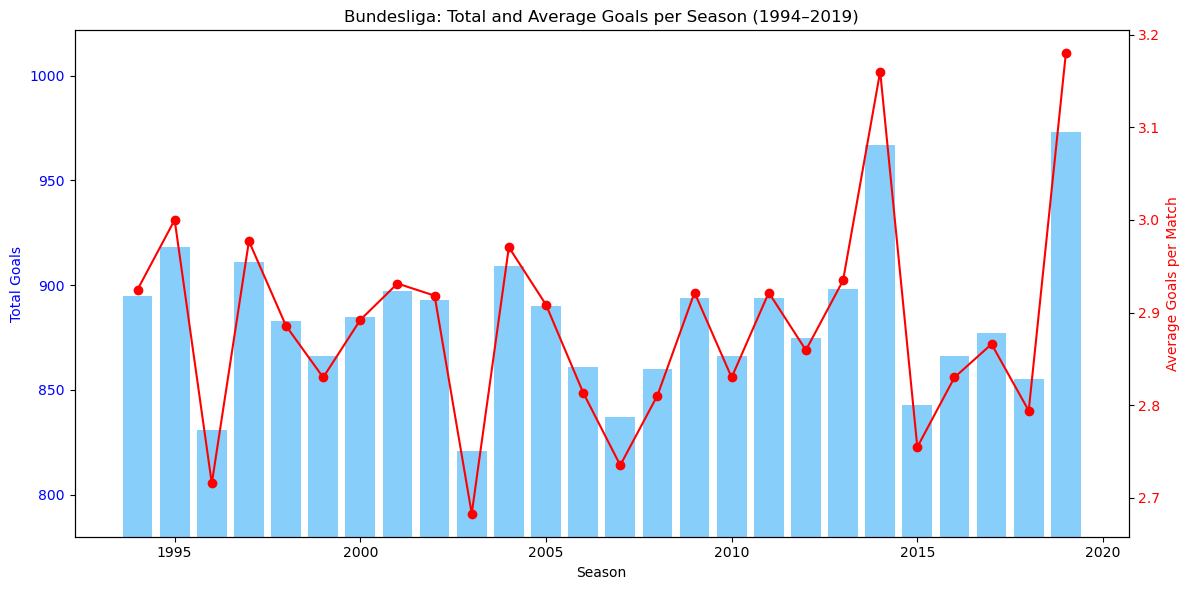

In [5]:
goals_per_season['avg_goals_per_match'] = goals_per_season['total_goals'] / goals_per_season['total_matches']
fig, ax1 = plt.subplots(figsize=(12, 6))

min_goals = goals_per_season['total_goals'].min()
ax1.set_ylim(min_goals * 0.95, goals_per_season['total_goals'].max() * 1.05)


ax1.bar(goals_per_season.index, goals_per_season['total_goals'], color='lightskyblue', label='Total Goals')
ax1.set_ylabel('Total Goals', color='blue')
ax1.set_xlabel('Season')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(goals_per_season.index, goals_per_season['avg_goals_per_match'], color='red', marker='o', label='Avg Goals/Match')
ax2.set_ylabel('Average Goals per Match', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Bundesliga: Total and Average Goals per Season (1994–2019)')
fig.tight_layout()
plt.show()

##### 2. Goal Distribution Per Season. Use appropriate type of graphs for goals per match, year-wise. Color code by whether average is above or below 2.5 (over/under bet threshold).

In [6]:
goals_per_season['over_2_5'] = goals_per_season['avg_goals_per_match'] >= 2.5
df = df.merge(goals_per_season[['over_2_5']], on='SEASON', how='left')

seasons = sorted(df['SEASON'].unique())
season_colors = ['blue' if goals_per_season.loc[season, 'over_2_5'] else 'red' for season in seasons]
data = [df[df['SEASON'] == season]['TOTAL_GOALS'] for season in seasons]

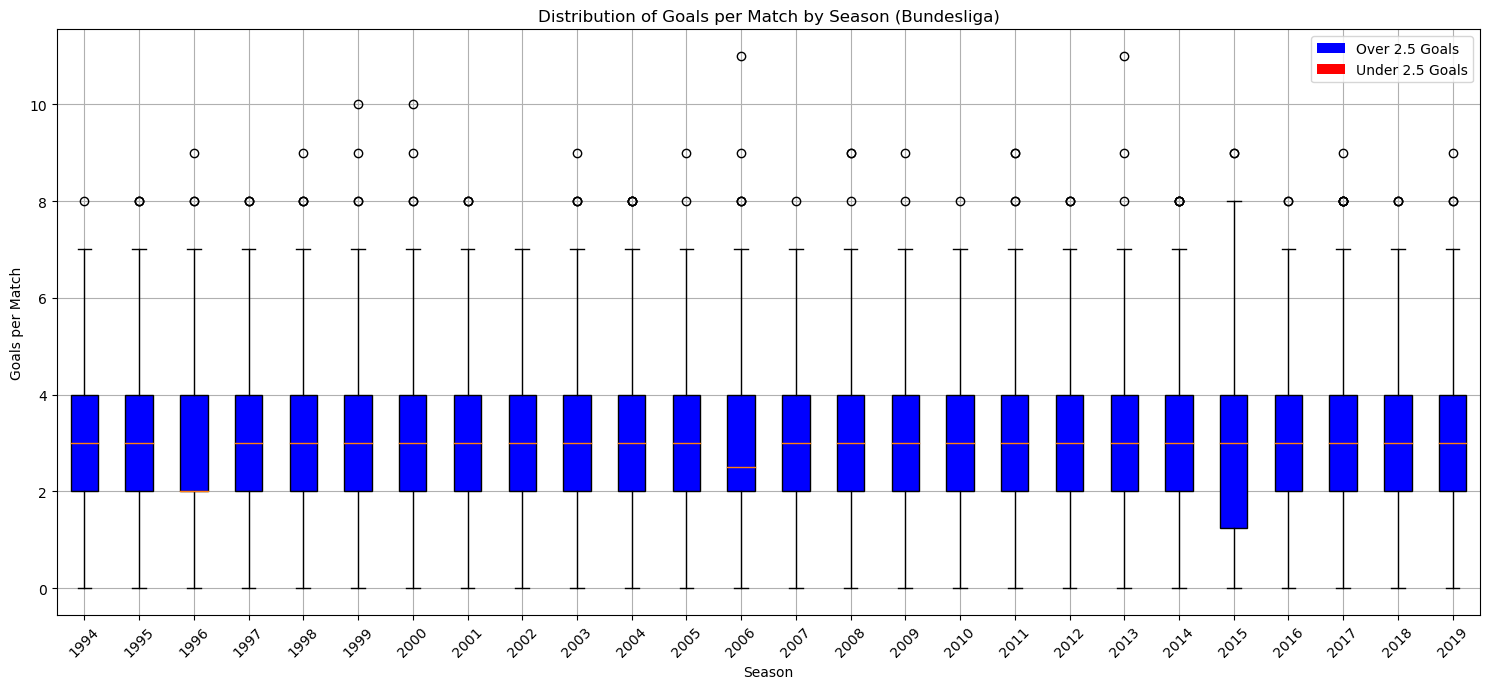

In [7]:
plt.figure(figsize=(15, 7))
box = plt.boxplot(data, patch_artist=True, labels=seasons)
for patch, color in zip(box['boxes'], season_colors):
    patch.set_facecolor(color)

    from matplotlib.patches import Patch
plt.legend(handles=[
    Patch(facecolor='blue', label='Over 2.5 Goals'),
    Patch(facecolor='red', label='Under 2.5 Goals')
])

plt.title('Distribution of Goals per Match by Season (Bundesliga)')
plt.xlabel('Season')
plt.ylabel('Goals per Match')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

###### 3. Create line charts for each season. Visualize trend of goals for each team that played in that season. Highlight only Bayern Munchen with red color. Rest should be gray. Add appropriate title that will contain information about season and total scored goals. Add footnote mentioning total number of goals scored by Bayern Munchen for that season. Save all graphs in pdf.

In [9]:
df['HOME_GOALS'] = df.groupby(['SEASON', 'HOMETEAM'])['FTHG'].transform('sum')
df['AWAY_GOALS'] = df.groupby(['SEASON', 'AWAYTEAM'])['FTAG'].transform('sum')
home_goals = df.groupby(['SEASON', 'HOMETEAM'])['FTHG'].sum().reset_index()
away_goals = df.groupby(['SEASON', 'AWAYTEAM'])['FTAG'].sum().reset_index()
home_goals.rename(columns={'HOMETEAM': 'TEAM', 'FTHG': 'GOALS'}, inplace=True)
away_goals.rename(columns={'AWAYTEAM': 'TEAM', 'FTAG': 'GOALS'}, inplace=True)
team_goals = pd.concat([home_goals, away_goals]).groupby(['SEASON', 'TEAM'])['GOALS'].sum().reset_index()
seasons = sorted(team_goals['SEASON'].unique())

In [84]:
with PdfPages("Part1.3_bundesliga_goals_per_team_per_season.pdf") as pdf:
    for season in seasons:

        season_data = team_goals[team_goals['SEASON'] == season].sort_values('GOALS', ascending=False)
        bayern_goals = season_data[season_data['TEAM'] == 'Bayern Munich']['GOALS'].sum()
        total_goals = season_data['GOALS'].sum()
        
        plt.figure(figsize=(10, 6))
        for team in season_data['TEAM'].unique():
            color = 'red' if team == 'Bayern Munich' else 'gray'
            plt.plot(season_data[season_data['TEAM'] == team]['TEAM'], 
                     season_data[season_data['TEAM'] == team]['GOALS'], 
                     marker='o', linestyle='-', color=color)

        plt.title(f"Goals per Team - Season {season}\nTotal Goals: {total_goals}", fontsize=14)
        plt.xlabel("Team")
        plt.ylabel("Total Goals")
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.figtext(0.5, -0.2, f"Bayern Munich scored {bayern_goals} goals in {season}", 
                    wrap=True, horizontalalignment='center', fontsize=10)

        pdf.savefig(bbox_inches='tight')
        plt.close()

print("PDF saved: bundesliga_goals_per_team_per_season.pdf")

PDF saved: bundesliga_goals_per_team_per_season.pdf


## Part 2: Home Advantage Deconstructed

##### 1. Create Heatmap of Home vs. Away Wins per Team per Season

In [19]:
df['HOME_WIN'] = df['FTHG'] > df['FTAG']
df['AWAY_WIN'] = df['FTAG'] > df['FTHG']
df['DRAW'] = df['FTHG'] == df['FTAG'] 

In [22]:
home_wins = df[df['HOME_WIN']].groupby(['SEASON', 'HOMETEAM']).size().unstack(fill_value=0)
away_wins = df[df['AWAY_WIN']].groupby(['SEASON', 'AWAYTEAM']).size().unstack(fill_value=0)
draws = df[df['DRAW']].groupby('SEASON').size()

In [23]:
home_wins = home_wins.sort_index(axis=1)
away_wins = away_wins.sort_index(axis=1)

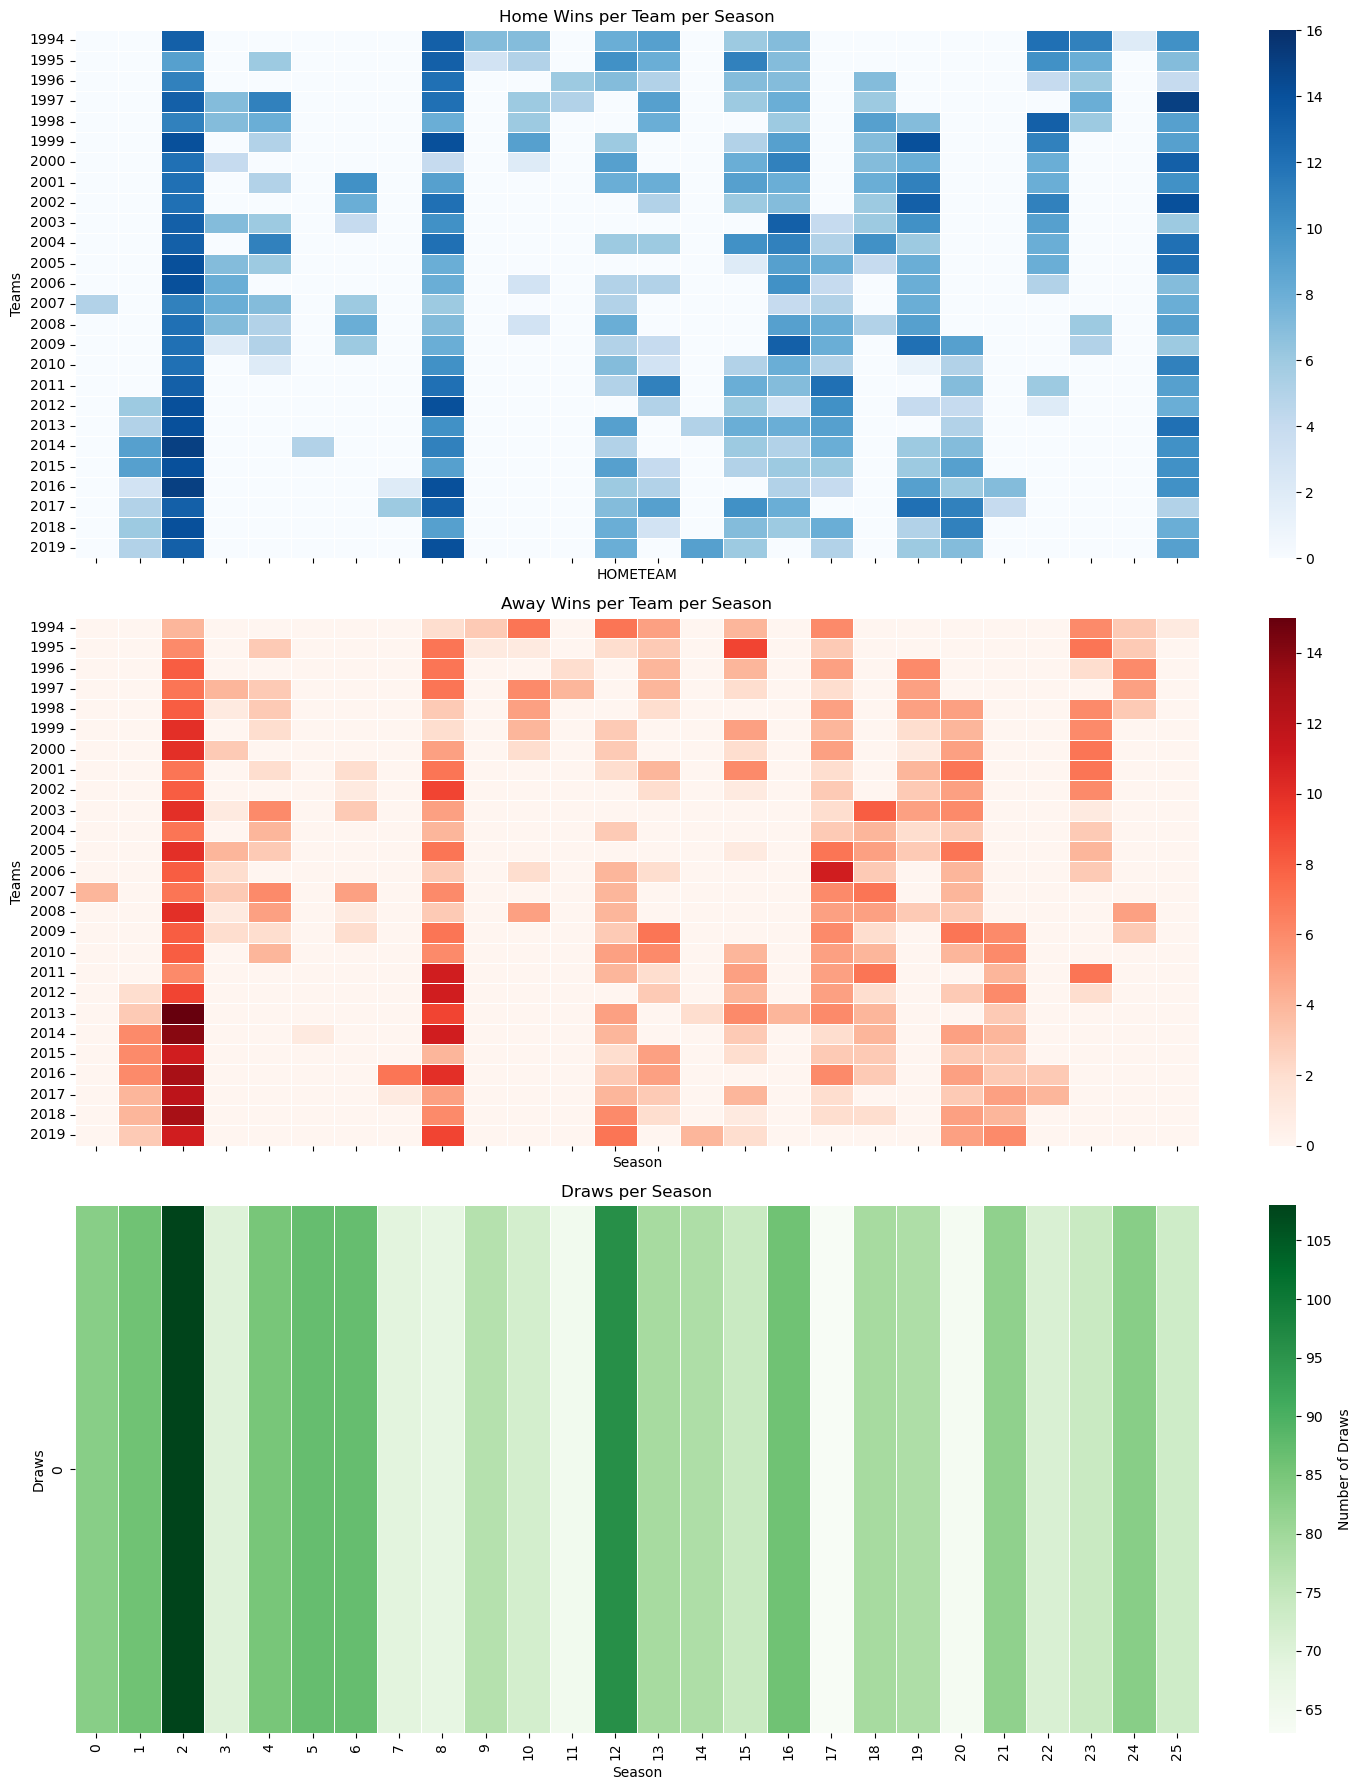

In [24]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 18), sharex=True)

sns.heatmap(home_wins, cmap="Blues", linewidths=0.5, ax=axes[0])
axes[0].set_title("Home Wins per Team per Season")
axes[0].set_ylabel("Teams")

sns.heatmap(away_wins, cmap="Reds", linewidths=0.5, ax=axes[1])
axes[1].set_title("Away Wins per Team per Season")
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Teams")

sns.heatmap(draws.values.reshape(1, -1), cmap="Greens", linewidths=0.5, ax=axes[2], cbar_kws={"label": "Number of Draws"})
axes[2].set_title("Draws per Season")
axes[2].set_xlabel("Season")
axes[2].set_ylabel("Draws")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#####  2. Point Differential Density: Create visualizations that will show difference per team for home and away game wins.

In [25]:
df['HOME_POINT_DIFF'] = df['FTHG'] - df['FTAG']
df['AWAY_POINT_DIFF'] = df['FTAG'] - df['FTHG']
home_wins = df[df['HOME_WIN']]
away_wins = df[df['AWAY_WIN']]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_30912\3532512020.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(home_wins['HOME_POINT_DIFF'], color='blue', shade=True, label='Home Win Point Differential', alpha=0.6)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30912\3532512020.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(away_wins['AWAY_POINT_DIFF'], color='red', shade=True, label='Away Win Point Differential', alpha=0.6)


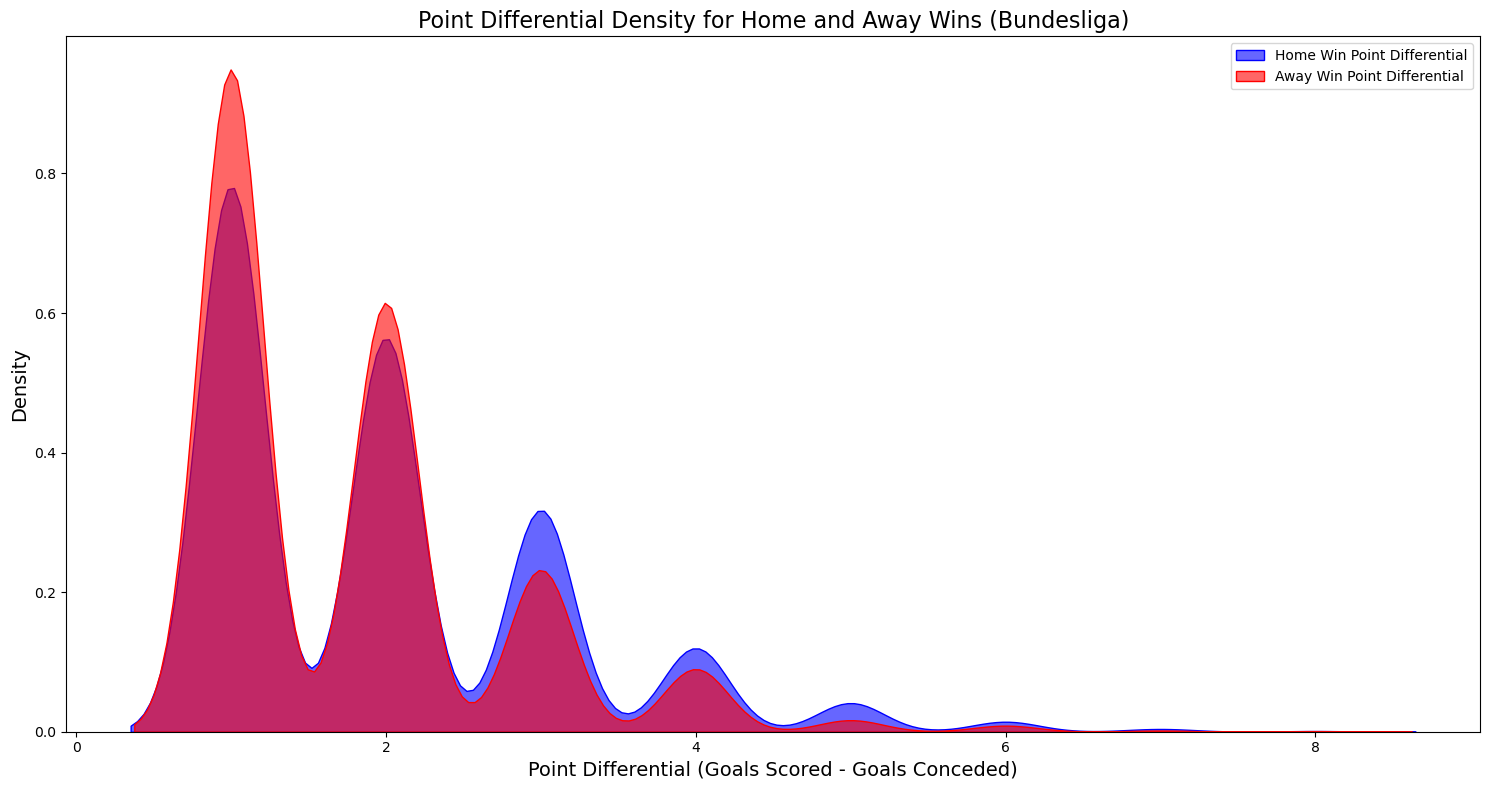

In [26]:
plt.figure(figsize=(15, 8))
sns.kdeplot(home_wins['HOME_POINT_DIFF'], color='blue', shade=True, label='Home Win Point Differential', alpha=0.6)
sns.kdeplot(away_wins['AWAY_POINT_DIFF'], color='red', shade=True, label='Away Win Point Differential', alpha=0.6)

plt.title("Point Differential Density for Home and Away Wins (Bundesliga)", fontsize=16)
plt.xlabel("Point Differential (Goals Scored - Goals Conceded)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Part 3:

##### 1. Team Trajectories and Volatility
##### • Seasonal Position Trajectories
##### • Line plots showing seasonal ranks for top 6 teams.
##### • Annotate title-winning seasons.

In [33]:
df2 = pd.read_csv("bundesliga2.csv")

In [34]:
top_6 = df2[df2['POSITION'] <= 6]

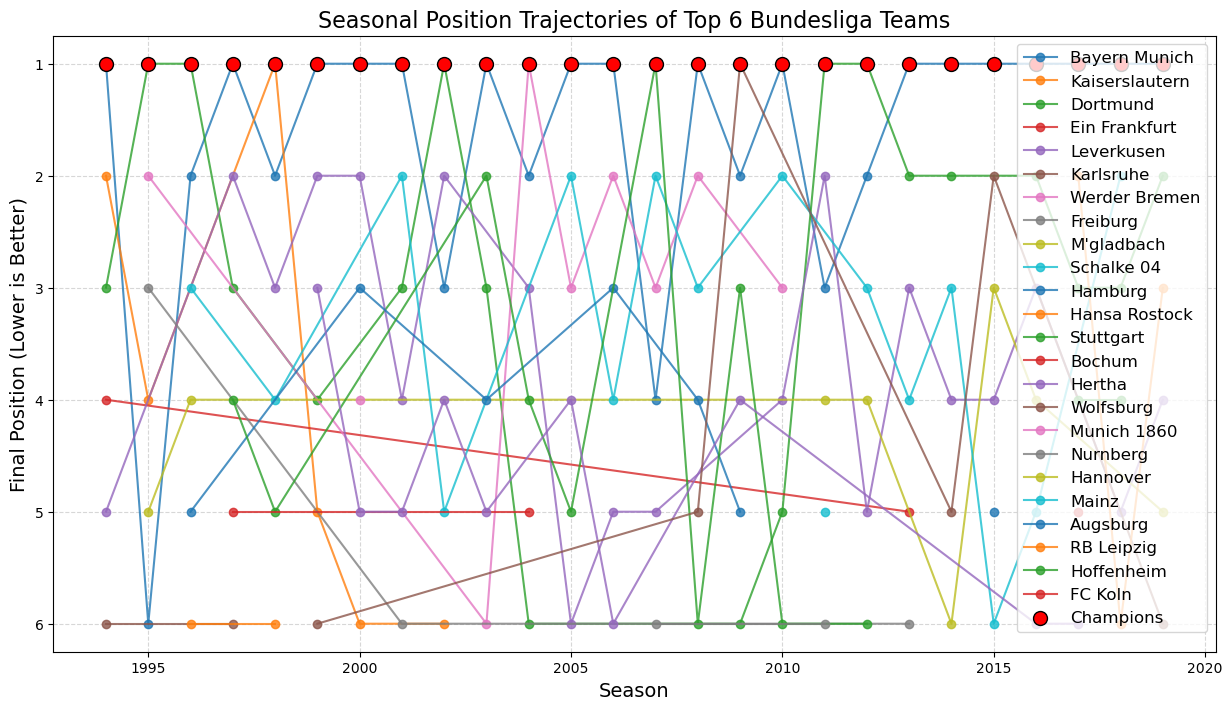

In [35]:
plt.figure(figsize=(15, 8))
teams = top_6['TEAM'].unique()
for team in teams:
    team_data = top_6[top_6['TEAM'] == team]
    plt.plot(team_data['SEASON'], team_data['POSITION'], marker='o', linestyle='-', label=team, alpha=0.8)

winners = top_6[top_6['POSITION'] == 1]
plt.scatter(winners['SEASON'], winners['POSITION'], color='red', s=100, label="Champions", edgecolors='black', zorder=3)

plt.gca().invert_yaxis()

plt.title("Seasonal Position Trajectories of Top 6 Bundesliga Teams", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Final Position (Lower is Better)", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#####  2. Volatility Index
##### • For each team, calculate standard deviation of final rank over all seasons.
##### • Use a bar chart with conditional coloring (e.g., red = unstable, green = consistent).
##### • Add text labels above each bar with exact values.

In [51]:
volatility = df2.groupby('TEAM')['POSITION'].std().reset_index()
volatility.columns = ['TEAM', 'STD_POSITION']
threshold = volatility['STD_POSITION'].median()

In [52]:
volatility['COLOR'] = ['green' if x < threshold else 'red' for x in volatility['STD_POSITION']]
volatility = volatility.sort_values(by='STD_POSITION', ascending=False)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


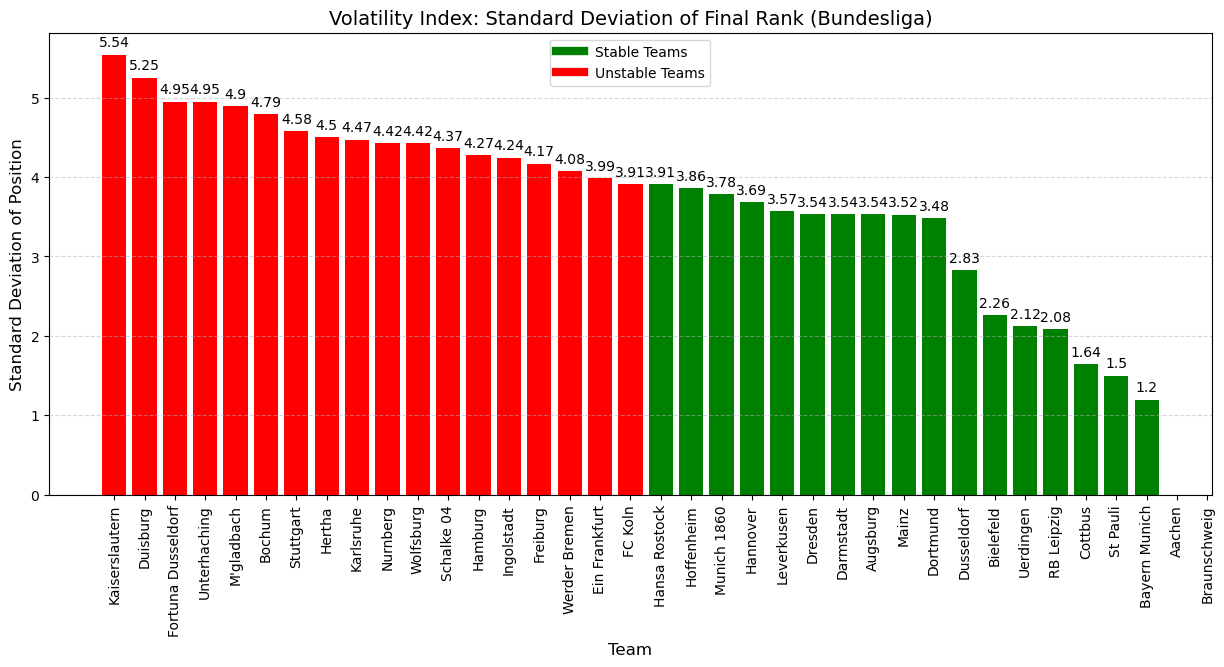

In [53]:
plt.figure(figsize=(15, 6))
bars = plt.bar(volatility['TEAM'], volatility['STD_POSITION'], color=volatility['COLOR'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', fontsize=10)

plt.title("Volatility Index: Standard Deviation of Final Rank (Bundesliga)", fontsize=14)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Standard Deviation of Position", fontsize=12)
plt.xticks(rotation=90)

plt.legend(handles=[
    plt.Line2D([0], [0], color='green', lw=6, label='Stable Teams'),
    plt.Line2D([0], [0], color='red', lw=6, label='Unstable Teams')
], loc="best")

plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.show()

## Part 4: Rivalries & Big Match Patterns

##### 1. Head-to-Head Matrix for Selected Rivalries
##### • Select 5 key rivalries more info click here .
##### • Create a facet grid of win/draw/loss bar charts per rivalry.
##### • Annotate biggest win margins.

In [54]:
rivalries = [
    ("Bayern Munich", "Dortmund"),
    ("Schalke 04", "Dortmund"),
    ("Bayern Munich", "M'gladbach"),
    ("Hamburg", "Werder Bremen"),
    ("Bayern Munich", "RB Leipzig") 
]

In [55]:
def get_match_result(row):
    if row["FTHG"] > row["FTAG"]:
        return "Home Win"
    elif row["FTHG"] < row["FTAG"]:
        return "Away Win"
    else:
        return "Draw"
df["Result"] = df.apply(get_match_result, axis=1)

In [58]:
rivalry_results = []
for team1, team2 in rivalries:
    matches = df[((df["HOMETEAM"] == team1) & (df["AWAYTEAM"] == team2)) |
                 ((df["HOMETEAM"] == team2) & (df["AWAYTEAM"] == team1))]

    matches = matches.copy()
    matches.loc[:, "Winner"] = matches.apply(lambda x: x["HOMETEAM"] if x["FTHG"] > x["FTAG"]
                                         else (x["AWAYTEAM"] if x["FTAG"] > x["FTHG"] else "Draw"), axis=1)
    
    rivalry_results.append(matches)

In [59]:
rivalry_df = pd.concat(rivalry_results)
rivalry_summary = rivalry_df.groupby(["HOMETEAM", "AWAYTEAM", "Result"]).size().reset_index(name="Count")

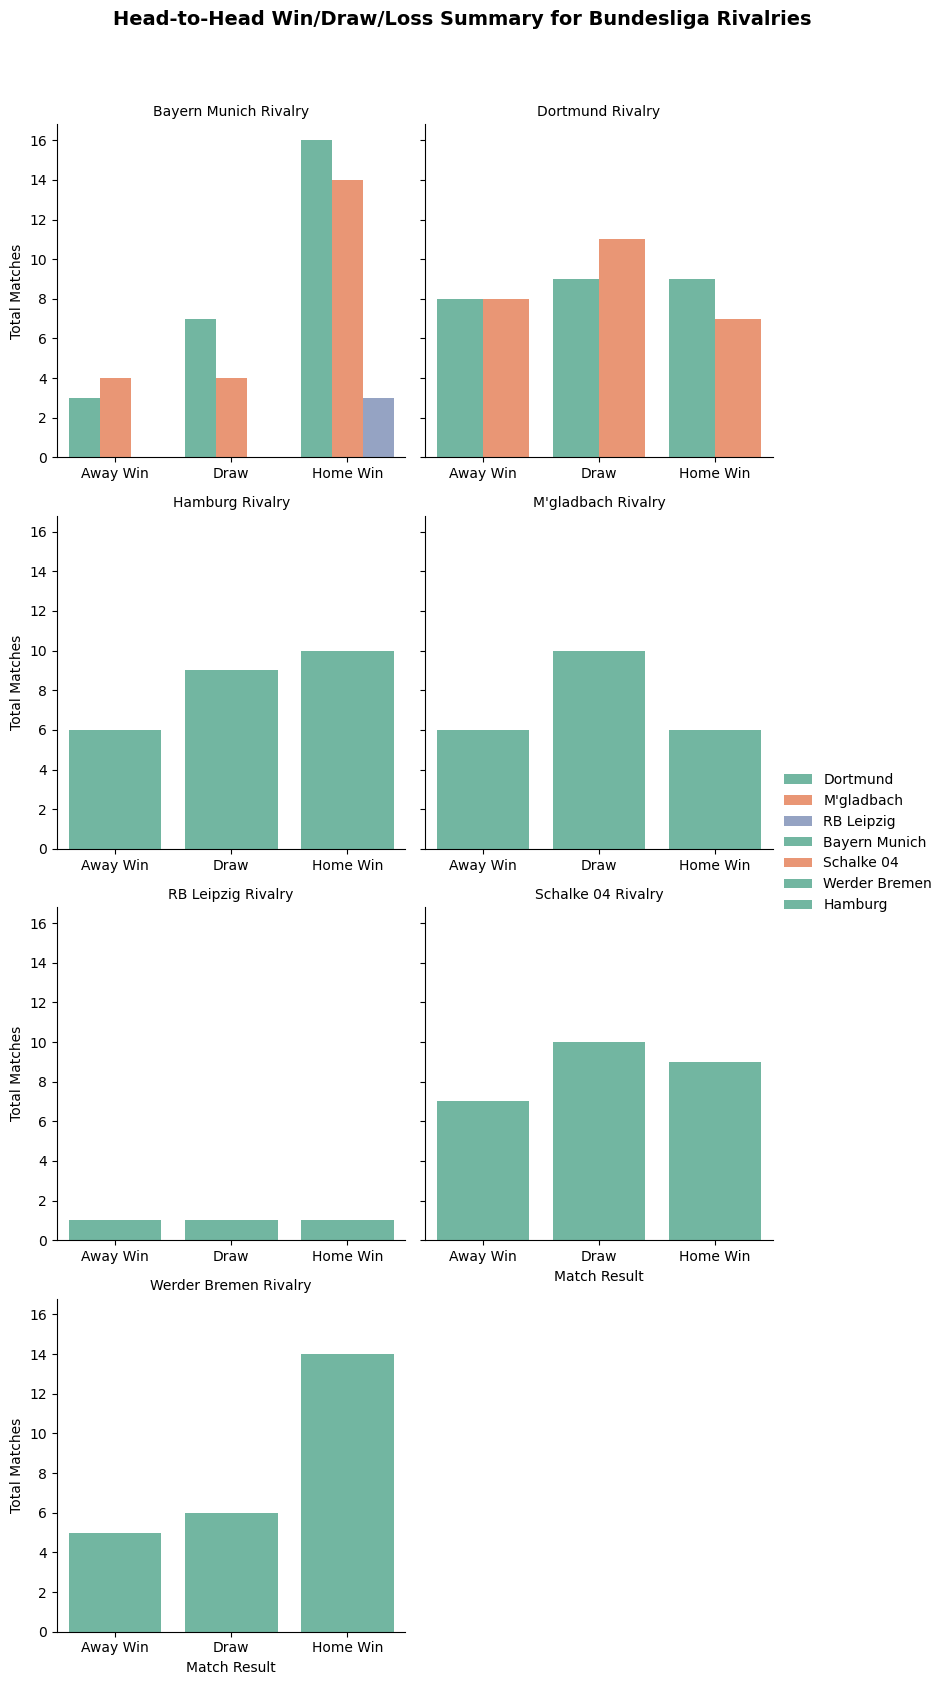

In [60]:
g = sns.FacetGrid(rivalry_summary, col="HOMETEAM", col_wrap=2, height=4, sharex=False)
g.map_dataframe(sns.barplot, x="Result", y="Count", hue="AWAYTEAM", palette="Set2")

g.set_titles("{col_name} Rivalry")
g.set_axis_labels("Match Result", "Total Matches")
g.add_legend()
plt.suptitle("Head-to-Head Win/Draw/Loss Summary for Bundesliga Rivalries", fontsize=14, fontweight="bold", y=1.05)
plt.show()

In [62]:
rivalry_df["Win_Margin"] = abs(rivalry_df["FTHG"] - rivalry_df["FTAG"])
biggest_wins = rivalry_df.loc[rivalry_df.groupby(["HOMETEAM", "AWAYTEAM"])["Win_Margin"].idxmax(),
                              ["HOMETEAM", "AWAYTEAM", "Win_Margin", "FTHG", "FTAG"]]

print("Biggest Win Margins in Rivalries:")
print(biggest_wins)

Biggest Win Margins in Rivalries:
           HOMETEAM       AWAYTEAM  Win_Margin  FTHG  FTAG
7587  Bayern Munich       Dortmund           6     6     0
7606  Bayern Munich     M'gladbach           4     5     1
7177  Bayern Munich     RB Leipzig           3     3     0
4932       Dortmund  Bayern Munich           4     1     5
2190       Dortmund     Schalke 04           4     0     4
2506        Hamburg  Werder Bremen           4     0     4
7861     M'gladbach  Bayern Munich           4     1     5
7331     RB Leipzig  Bayern Munich           1     4     5
4298     Schalke 04       Dortmund           3     4     1
3335  Werder Bremen        Hamburg           6     6     0


##### 2. Upset Visualizer
##### • Define “upset” as a team >8 places below beating a top-5 team.
##### • Scatterplot of upsets: x-axis = rank difference, y-axis = goal difference.
##### • Encode team colors; highlight and label famous upsets

In [64]:
def is_upset(row, home_team_rank, away_team_rank):
    if home_team_rank <= 5 and away_team_rank > home_team_rank + 8 and row["FTAG"] > row["FTHG"]:
        return True
    elif away_team_rank <= 5 and home_team_rank > away_team_rank + 8 and row["FTHG"] > row["FTAG"]:
        return True
    return False

In [65]:
df = df.merge(df2[['TEAM', 'POSITION', 'SEASON']], 
              left_on=['HOMETEAM', 'SEASON'], 
              right_on=['TEAM', 'SEASON'], 
              how='left').rename(columns={'POSITION': 'HOME_POS'})

df = df.merge(df2[['TEAM', 'POSITION', 'SEASON']], 
              left_on=['AWAYTEAM', 'SEASON'], 
              right_on=['TEAM', 'SEASON'], 
              how='left').rename(columns={'POSITION': 'AWAY_POS'})

In [66]:
df['Upset'] = df.apply(lambda row: is_upset(row, row['HOME_POS'], row['AWAY_POS']), axis=1)
upsets = df[df["Upset"]].copy()

In [67]:
upsets["Rank_Diff"] = abs(upsets["HOME_POS"] - upsets["AWAY_POS"])
upsets["Goal_Diff"] = abs(upsets["FTHG"] - upsets["FTAG"])

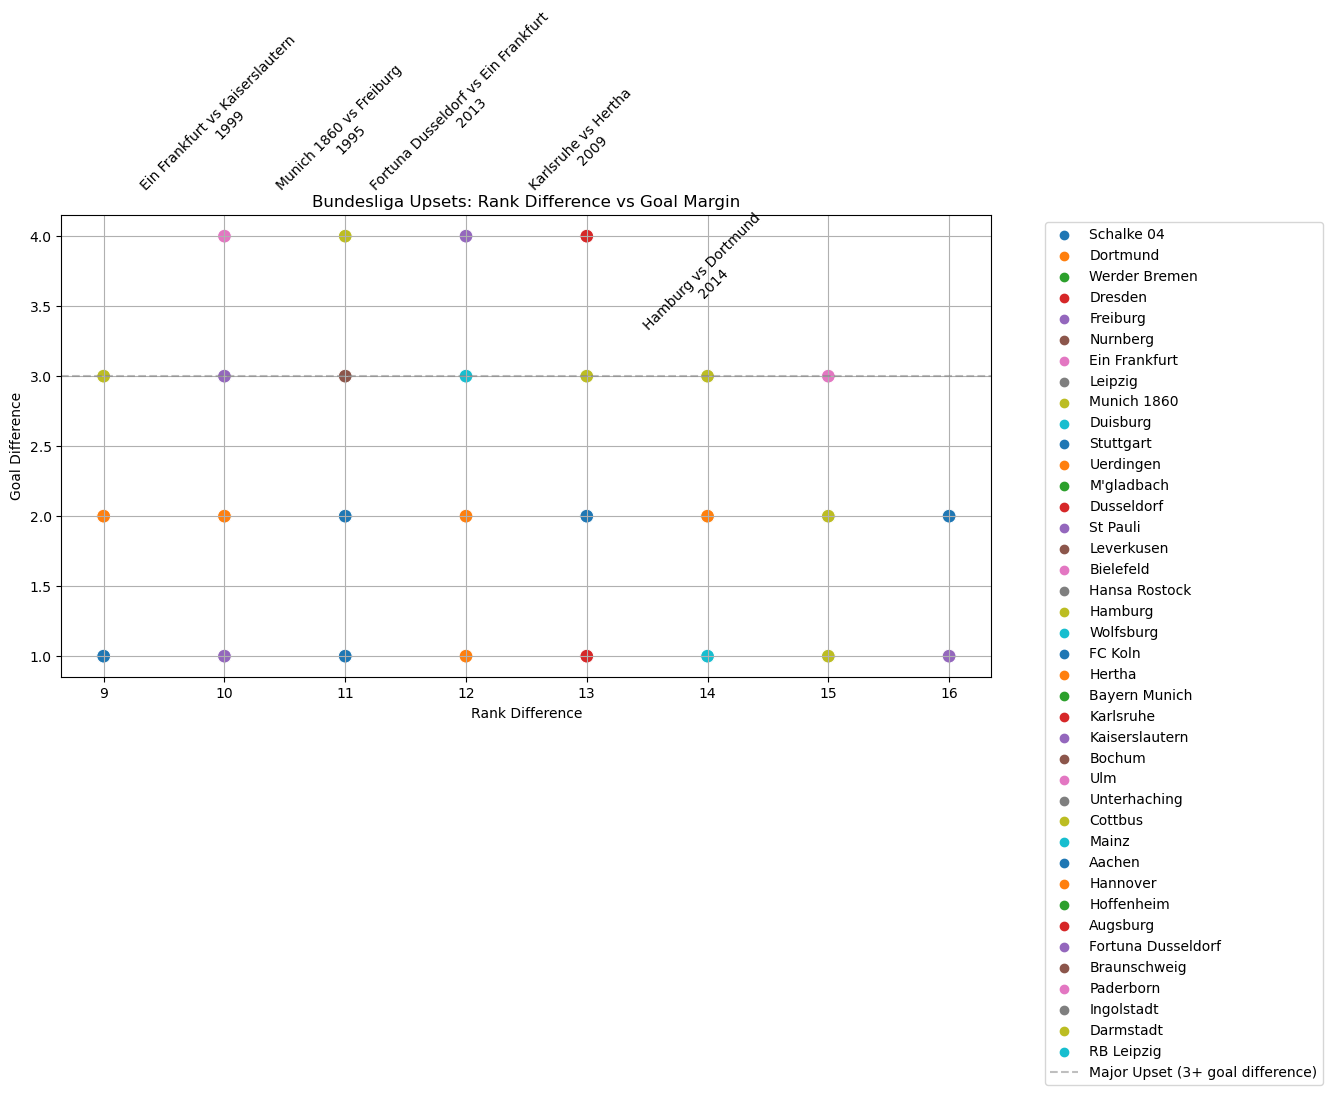

In [78]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=upsets, x="Rank_Diff", y="Goal_Diff", hue="HOMETEAM", palette="tab10", s=100)

biggest_upsets = upsets.sort_values(by="Goal_Diff", ascending=False).head(5)
for _, row in biggest_upsets.iterrows():
    plt.annotate(f"{row['HOMETEAM']} vs {row['AWAYTEAM']}\n{row['SEASON']}", 
                 (row["Rank_Diff"], row["Goal_Diff"]), 
                 textcoords="offset points", xytext=(0,25), ha='center', rotation=45)

plt.axhline(y=3, color='gray', linestyle='dashed', alpha=0.5, label="Major Upset (3+ goal difference)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Rank Difference")
plt.ylabel("Goal Difference")
plt.title("Bundesliga Upsets: Rank Difference vs Goal Margin")
plt.grid(True)
plt.show()

## Part 5: Overall performance

##### • Define unique color for each team per season. For each season create horizontal bar plot using  goal difference. Highlighting the winner with the unique color that you assigned to it. Save all graphs in pdf.

In [81]:
teams = df2['TEAM'].unique()
team_colors = sns.color_palette("Set3", len(teams))  # You can change the color palette
team_color_map = dict(zip(teams, team_colors))

In [83]:
with PdfPages('Part5_Python_Bundesliga_Season_GoalDifference_Performance.pdf') as pdf:
    
    seasons = df2['SEASON'].unique()

    for season in seasons:
        season_data = df2[df2['SEASON'] == season]
        winner = season_data.loc[season_data['POSITION'] == 1, 'TEAM'].values[0]

        plt.figure(figsize=(10, 6))
        sns.barplot(data=season_data, x='DIFF', y='TEAM', palette=team_color_map, dodge=False)

        bars = plt.gca().patches
        for bar, team in zip(bars, season_data['TEAM']):
            if team == winner:
                bar.set_facecolor('gold')
                
        plt.title(f'Bundesliga {season} Goal Difference Performance', fontsize=16)
        plt.xlabel('Goal Difference', fontsize=14)
        plt.ylabel('Team', fontsize=14)

        pdf.savefig()
        plt.close()

print("PDF has been saved successfully.")

PDF has been saved successfully.


## Part 6. Monte Carlo simulation.

##### Use Monte Carlo simulation to predict how many goals will Bayern Munchen score for next 10 seasons. Repeat the same for Bayer Leverkusen and Borusia Dortmund. Compare results using appropriate visualization technique.

In [89]:
teams = ['Bayern Munich', 'Bayer Leverkusen', 'Borussia Dortmund']
df_teams = df[df['HOMETEAM'].isin(teams) | df['AWAYTEAM'].isin(teams)]

In [90]:
def calculate_goals(team):
    home_goals = df_teams[df_teams['HOMETEAM'] == team]['FTHG'].values  # Home goals
    away_goals = df_teams[df_teams['AWAYTEAM'] == team]['FTAG'].values  # Away goals
    total_goals = np.concatenate([home_goals, away_goals])  # Total goals scored in all matches
    return total_goals

In [91]:
team_stats = {}
for team in teams:
    total_goals = calculate_goals(team)
    avg_goals = np.mean(total_goals) if len(total_goals) > 0 else 0
    std_dev = np.std(total_goals) if len(total_goals) > 0 else 0
    team_stats[team] = (avg_goals, std_dev)

In [92]:
n_simulations = 1000
n_seasons = 10
simulations = {}

In [93]:
for team, (avg_goals, std_dev) in team_stats.items():
    if avg_goals > 0 and std_dev > 0:
        simulations[team] = np.random.normal(loc=avg_goals, scale=std_dev, size=(n_simulations, n_seasons))
    else:
        simulations[team] = np.zeros((n_simulations, n_seasons))

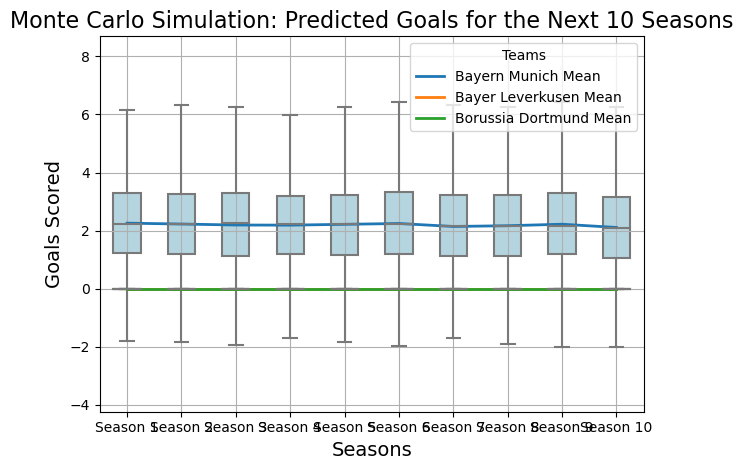

In [94]:
for team in teams:
    sns.boxplot(data=simulations[team], color='lightblue', width=0.5, fliersize=0)
    plt.plot(np.mean(simulations[team], axis=0), label=f'{team} Mean', linewidth=2)

plt.title("Monte Carlo Simulation: Predicted Goals for the Next 10 Seasons", fontsize=16)
plt.xlabel("Seasons", fontsize=14)
plt.ylabel("Goals Scored", fontsize=14)
plt.legend(title="Teams", loc='upper right')
plt.xticks(np.arange(n_seasons), [f"Season {i+1}" for i in range(n_seasons)])
plt.grid(True)
plt.tight_layout()
plt.show()